# 高斯模糊

In [1]:
import numpy as np
import cupy as cp
import cv2
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel(src,kname):
    _ = cp.zeros((1,)) # 初始化cuda context
    kernel = cp.core.core.compile_with_cache(src).get_function(kname)
    return kernel

In [12]:
sources = string.Template("""
extern "C" {

__global__
void gaussian_blur(const  float* const inputChannel,
                    float* const outputChannel,
                   int numRows, int numCols, const float* const filter, const int filterWidth)
{
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  if ( col >= numCols || row >= numRows )
  {
   return;
  }

  float result = 0.f;
    //For every value in the filter around the pixel (c, r)
    for (int filter_r = -filterWidth/2; filter_r <= filterWidth/2; ++filter_r) 
    {
      for (int filter_c = -filterWidth/2; filter_c <= filterWidth/2; ++filter_c) 
      {
        //Find the global image position for this filter position
        //clamp to boundary of the image
        int image_r = min(max(row + filter_r, 0), static_cast<int>(numRows - 1));
        int image_c = min(max(col + filter_c, 0), static_cast<int>(numCols - 1));

        float image_value = static_cast<float>(inputChannel[image_r * numCols + image_c]);
        float filter_value = filter[(filter_r + filterWidth/2) * filterWidth + filter_c + filterWidth/2];

        result += image_value * filter_value;
      }
    }
  outputChannel[row * numCols + col] = result;
}

}
""").substitute()

In [13]:
gaussian_filter = load_kernel(sources,'gaussian_blur')

In [14]:
src = cv2.imread('../../datas/f2.jpg',0)

In [21]:
height,width = src.shape
dim_block = (32,32)
grid = ((dim_block[0] + width - 1) // dim_block[0],
        (dim_block[1] + height - 1) // dim_block[1])
src_cu = cp.asarray(src).astype(cp.float32)
dst_cu = cp.zeros(src.shape,dtype=cp.float32)
kernel = cp.array([
    [-1,-1,-1],
    [-1,9,-1],
    [-1,-1,-1]
]).astype(cp.float32)

In [22]:
gaussian_filter(grid=grid,block=dim_block,args=(src_cu,dst_cu,height,width,kernel,3))

In [23]:
dst = dst_cu.get()
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = np.uint8(np.abs(dst))

([], <a list of 0 Text yticklabel objects>)

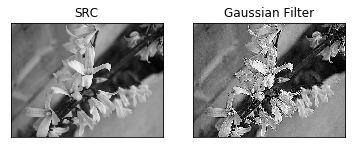

In [24]:
plt.subplot(121)
plt.imshow(src,'gray')
plt.title('SRC')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Gaussian Filter')
plt.xticks([])
plt.yticks([])

Text(0.5,1,'Different')

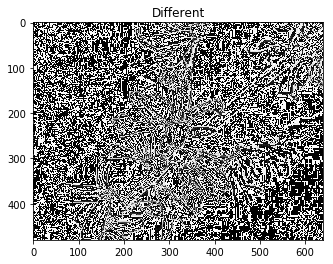

In [25]:
plt.imshow(np.abs(dst - src),'gray')
plt.title('Different')

参考：

[1]. https://www.cnblogs.com/magic8sky/p/6104377.html